In [262]:
import os
import sys
import itertools

import numpy as np
import pandas as pd
import scipy.stats as stats
import scipy.signal as sig
import scipy.io as spio

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import networkx as nx
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

sys.path.append("../../../code/ndsvae/")
import ndsvae as ndsv

sys.path.append("../")
import util
import plotutils as pu

%matplotlib inline

In [212]:
config = "ns_3_mreg_3_msub_2_nf_32"
conn = "linw"
preproc = "dicer"
modelname = "AB"

ds = ndsv.Dataset.from_file(f"../run/hcp/hcp_{conn}_{preproc}/dataset.npz")
run = util.select_run(f"hcp_{conn}_{preproc}", modelname, config, [0,1], "hcp")
direc = f"../run/hcp/hcp_{conn}_{preproc}/model{modelname}/{config}/run{run:02d}"
params = ndsv.Params.from_file(os.path.join(direc, "parameters.npz"))

In [213]:
run

0

In [214]:
nsub, nreg, _, nt = ds.y.shape
subjects = np.r_[:nsub]
regions = np.r_[:nreg]

### Build dataframe

In [215]:
df = pd.DataFrame(list(itertools.product(subjects, regions)), columns=['subject', 'region'])

### Structural properties

In [216]:
df['instrength']  = np.sum(ds.w, axis=2).ravel()

In [217]:
centrality = np.zeros((nsub, nreg))

for i in range(nsub):
    w = nx.from_numpy_array(ds.w[i])
    cent = nx.eigenvector_centrality_numpy(w, weight='weight')
    centrality[i][list(cent.keys())] = list(cent.values())

df['centrality'] = centrality.ravel()    

### Functional network

In [218]:
df[['pca1', 'pca2', 'pca3', 'pca4', 'pca5']] = 0.
df['corr_with_mean'] = 0.
df['corr_with_input'] = 0.
df['mean_fc'] = 0.

for i in range(nsub):
    ncomp = 5
    y = ds.y[i,:,0,:].T              # (n_samples, n_features)
    pca = PCA(n_components=ncomp).fit(y)
    mask = (df.subject == i)    
    ymean = np.mean(y, axis=1)    
    ybar = pca.transform(y)
        
    for icomp in range(5):
        sign = 1 if (np.corrcoef(ybar[:,icomp], ymean)[0,1] > 0) else -1
        df.loc[mask, f"pca{icomp+1}"] = sign * pca.components_[icomp]    
        
    df.loc[mask, 'corr_with_mean']  = np.corrcoef(y.T, np.mean(y, axis=1))[-1,:-1]
    df.loc[mask, 'corr_with_input'] = np.corrcoef(y.T, params.us[i,:,0])[-1,:-1]
    
    fc = np.corrcoef(y.T)
    df.loc[mask, 'mean_fc'] = np.mean(fc, axis=1)

In [219]:
df['corr_with_network_input'] = 0.
df['corr_with_neighbor'] = 0.

for i in range(nsub):
    w = ds.w[i]
    y = ds.y[i,:,0,:]
    unet = w @ y
    uneigh = y[np.argmax(w, axis=1),:]
    
    mask = (df.subject == i)
    df.loc[mask, 'corr_with_network_input'] = [np.corrcoef(y[j], unet[j])[0,1] for j in range(nreg)]
    df.loc[mask, 'corr_with_neighbor']      = [np.corrcoef(y[j], uneigh[j])[0,1] for j in range(nreg)]

### Signal properties

In [220]:
df[['mean', 'variance', 'skewness', 'kurtosis']] = 0.

for i in range(nsub):
    y = ds.y[i,:,0,:]
    mask = (df.subject == i)    
    df.loc[mask, 'mean'] = np.mean(y, axis=1)
    df.loc[mask, 'variance'] = np.var(y, axis=1)
    df.loc[mask, 'skewness'] = stats.skew(y, axis=1)
    df.loc[mask, 'kurtosis'] = stats.kurtosis(y, axis=1)

In [221]:
def zero_crossings(y):
    # At first axis
    above = (y > 0)
    return np.sum(above[1:] != above[:-1], axis=0)

df["zero_crossings"] = 0

for i in range(nsub):
    y = ds.y[i,:,0,:].T
    df.loc[(df.subject == i), "zero_crossings"] = zero_crossings(y)

In [222]:
# power in different bands
T = 0.720
freq_boundary = 0.1

df["power_high"] = 0.
df["power_low"] = 0.

for i in range(nsub):
    y = ds.y[i,:,0,:]   
    freqs, psd = sig.welch(y, 1/T, scaling='density', nperseg=128)
    mask = (df.subject == i)
    low_freq = (freqs < freq_boundary)
   
    df.loc[mask, 'power_high']  = np.sum(psd[:, ~low_freq], axis=1)
    df.loc[mask, 'power_low'] = np.sum(psd[:, low_freq], axis=1)
    # df.loc[mask, 'Peak frequency above 0.1 Hz'] = freqs[~low_freq][np.argmax(psd[:, ~low_freq], axis=1)]
    # df.loc[mask, 'Peak frequency below 0.1 Hz'] = freqs[low_freq][np.argmax(psd[:, low_freq], axis=1)]

### Von Economo-Koskinas data from Wang et al. (2019)

https://github.com/ThomasYeoLab/CBIG/tree/master/stable_projects/fMRI_dynamics/Wang2018_MFMem

In [223]:
data = spio.loadmat("../etc/WangEtAl19/ECONOMO_data_Martijn.mat")

layers = ['I', 'II', 'III', 'IV', 'V', 'VI']
neuronal_size = np.nanmean([data[f"layer{layer}total_cell_content_cellsize_aparc"][0] for layer in layers], axis=0)
neuronal_density = np.nanmean([data[f"layer{layer}total_cell_content_mm3_aparc"][0] for layer in layers], axis=0)

df['neuronal_size'] = 0.
df['neuronal_density'] = 0.

for i in range(nsub):
    mask = (df.subject == i)
    df.loc[mask, 'neuronal_size'] = np.concatenate([neuronal_size, neuronal_size])
    df.loc[mask, 'neuronal_density'] = np.concatenate([neuronal_density, neuronal_density])


### Myelin, RSFC gradient, and gene expression data from Kong et al. (2021)

https://github.com/ThomasYeoLab/CBIG/tree/master/stable_projects/fMRI_dynamics/Kong2021_pMFM/input/Desikan_input

In [224]:
myelin = np.loadtxt("../etc/KongEtAl21/myelin.csv")
rsfc_gradient = np.loadtxt("../etc/KongEtAl21/rsfc_gradient.csv")

df['myelin'] = 0.
df['rsfc_gradient'] = 0.

for i in range(nsub):
    mask = (df.subject == i)
    df.loc[mask, 'myelin'] = myelin
    df.loc[mask, 'rsfc_gradient'] = rsfc_gradient
    
    
data = spio.loadmat("../etc/KongEtAl21/gene_data.mat")
for i in range(nsub):
    mask = (df.subject == i)
    df.loc[mask, 'kong_pc'] = data['PC1'][:,0]
    df.loc[mask, 'kong_pvalb_sst'] = data['PVALB'][:,0] - data['SST'][:,0]

### Corrected Von Economo data

In [ ]:
def nanaverage(x, weights):
    return np.nansum(x*weights) / ((~np.isnan(x)) * weights).sum()


region_names = np.genfromtxt("../data/100307/region_names.txt", usecols=(0), dtype=str)
region_names = [r[7:] for r in region_names[:34]]

dfve = pd.read_csv("../etc/VonEconomo/table_dk34.csv")

dfg = dfve.groupby(['area'])
dfve = pd.concat([
    dfg.apply(lambda x: np.nansum(x.thickness)),
    dfg.apply(lambda x: nanaverage(x.density,  weights=x.thickness)),
    dfg.apply(lambda x: nanaverage(x.cellsize, weights=x.thickness))
    ], axis=1, keys=['thickness', 'density', 'cellsize'])

# Sort
dfve = dfve.loc[region_names].reset_index()

# Add to the dataframe
for i in range(nsub):
    mask = (df.subject == i)
    df.loc[mask, 'neuronal_size_corr'] = np.concatenate([dfve.cellsize, dfve.cellsize])
    df.loc[mask, 'neuronal_density_corr'] = np.concatenate([dfve.density, dfve.density])

### BigBrain data

In [227]:
def read_bb(filename):
    bb = pd.read_excel(filename, index_col=0)
    bb['area'] = [r.replace("right ", "ctx-rh-").replace("left ", "ctx-lh-").replace(' ', '') for r in bb.region]
    bb = bb.set_index("area")    
    
    region_names = np.genfromtxt("../data/100307/region_names.txt", usecols=(0), dtype=str)
    
    bb = bb.reindex(region_names)
    return bb



bb = read_bb("../etc/BigBrain/DESIKAN_KILLIANY_2006_density_estimates.xlsx")
density = bb[[f'layer {j}' for j in range(1,7)]].values
pca = sklearn.decomposition.PCA(n_components=6)
y = pca.fit_transform(density)


df['neuronal_density_bb'] = 0.
df['neuronal_density_bb_1'] = 0.
df['neuronal_density_bb_2'] = 0.
df['neuronal_density_bb_3'] = 0.
df['neuronal_density_bb_4'] = 0.
df['neuronal_density_bb_5'] = 0.
df['neuronal_density_bb_6'] = 0.

df['bb_pca_1'] = 0.
df['bb_pca_2'] = 0.

for i in range(nsub):
    mask = (df.subject == i)
    df.loc[mask, 'neuronal_density_bb'] = 1000*bb.cortex.values
    for j in range(1,7):
        df.loc[mask, f'neuronal_density_bb_{j}'] = 1000*bb[f'layer {j}'].values
    
    df.loc[mask, 'bb_pca_1'] = y[:,0]
    df.loc[mask, 'bb_pca_2'] = y[:,1]
    

### Deco et al. (2021) data

https://github.com/KevinAquino/HNM/tree/main/InputData

In [230]:
pc = spio.loadmat("../etc/DecoEtAl21/APARC_genedata.mat")['data']                     # PC
t1t2 = spio.loadmat("../etc/DecoEtAl21/myelin_HCP_dk68.mat")['t1t2Cortex'][0]         # T1w:T2w

# See GranModelOptimization/slurm.sbatch_genes_balanced_gain.m in https://github.com/KevinAquino/HNM
data = spio.loadmat("../etc/DecoEtAl21/DKcortex_selectedGenes.mat")['expMeasures']    # E:I

# Matlab index: 18-25 (18:21 ampa+ 22:25 nmda/gaba)
# Matlab indexes from 1 and includes last element
coef_e = np.sum(data[:, 17:25], axis=1)
coef_i = np.sum(data[:, np.r_[1:9,11:14]], axis=1)

ratio_e = coef_e / np.max(coef_e)
ratio_i = coef_i / np.max(coef_i)
ratio_ei = ratio_e / ratio_i

df['deco_pc'] = 0.
df['deco_t1t2'] = 0.
df['deco_ei'] = 0.

for i in range(nsub):
    mask = (df.subject == i)
    df.loc[mask, 'deco_pc'] = np.concatenate([pc, pc])
    df.loc[mask, 'deco_t1t2'] = t1t2
    df.loc[mask, 'deco_ei'] = np.concatenate([ratio_ei, ratio_ei])

### Inferred parameters

In [255]:
mreg = params.thetareg.shape[2]

In [256]:
for i in range(mreg):
    df[f'thetareg{i}_mu']  = params.thetareg[:,:,i,0].ravel()
    df[f'thetareg{i}_std'] = params.thetareg[:,:,i,1].ravel()

## Sample

In [271]:
np.random.seed(42)

nsamples = 1
dfs = df.loc[df.index.repeat(nsamples)]

dfs['thetareg0'] = dfs.thetareg0_mu # + dfs.thetareg0_std*np.random.normal(0, 1, size=len(dfs))
dfs['thetareg1'] = dfs.thetareg1_mu # + dfs.thetareg1_std*np.random.normal(0, 1, size=len(dfs))
dfs['thetareg2'] = dfs.thetareg2_mu # + dfs.thetareg2_std*np.random.normal(0, 1, size=len(dfs))

## Correlations?

In [272]:
order = np.array([1,2,0]) # Check Fig_HCP_ParamSpaceReg for this

In [291]:
parameters = ['thetareg0', 'thetareg1', 'thetareg2']

feature_groups = [
    ("Individual data", [        
        ("SC: Node in-strength", 'instrength'),
        ("SC: Node centrality", "centrality"),
        ("fMRI: First PCA eigenvector", "pca1"), 
        ("fMRI: Second PCA eigenvector", "pca2"),
        ("fMRI: Correlation with mean signal", "corr_with_mean"),
        ("fMRI: Correlation with network input", "corr_with_network_input"),
        ("fMRI: Number of zero-crossings", "zero_crossings"),
        ("fMRI: Power below 0.1 Hz", "power_low")
    ]),
    ("External data", [
        ("Neuronal size (Von Economo)", "neuronal_size_corr"),
        ("Neuronal density (Von Economo)", "neuronal_density_corr"),        
        ("Neuronal density (Big Brain)", "neuronal_density_bb"),
        ("RSFC principal gradient", "rsfc_gradient"),        
        ("T1w/T2w ratio", "myelin"),
        ("Gene expression map (first PC)", "deco_pc"),
        ("EI map", "deco_ei"),
        # ("Gene expression map (Kong)", "kong_pc"),
        # ("PVALB-SST", "kong_pvalb_sst")
    ])
]


for group_name, features in feature_groups:
    print(f"    {group_name}")
    for (label, feature) in features:
        norm_feature = dfs[feature].copy()
        norm_feature -= np.mean(norm_feature)
        norm_feature /= np.std(norm_feature)

        
        mod = sm.OLS(norm_feature, sm.add_constant(dfs[parameters], prepend=False))
        fii = mod.fit()
        r2 = fii.rsquared_adj
        p_values = fii.summary2().tables[1]['P>|t|'][:3][order]
        weights = fii.summary2().tables[1]['Coef.'][:3][order]
        
        print(f"    & {label:30s} &", end="")
        print(f"\\textbf{{{r2:.2f}}}" if r2 > 0.3 else f"        {r2:.2f} " , end=" ")
        for i in range(len(parameters)):
            val = weights[i]
            pval = p_values[i]
            
            if pval >= 0.05: 
                print(f"& \\textcolor{{gray}}{{{val:6.2f}}}", end="")
            elif r2 > 0.3 and np.abs(val) > 0.2:
                print(f"& \\textbf{{{val:6.2f}}}", end="")
            else:
                print(f"& {val:6.2f}", end="")
        print("  \\\\")
        
    print("    \hline")

    Individual data
    & SC: Node in-strength           &\textbf{0.49} & \textbf{ -0.62}& \textcolor{gray}{ -0.04}& \textbf{ -0.39}  \\
    & SC: Node centrality            &\textbf{0.30} & \textbf{ -0.46}&  -0.11& \textbf{ -0.33}  \\
    & fMRI: First PCA eigenvector    &\textbf{0.76} &  -0.20& \textbf{ -0.88}&   0.05  \\
    & fMRI: Second PCA eigenvector   &        0.04  & \textcolor{gray}{  0.02}&   0.18&   0.16  \\
    & fMRI: Correlation with mean signal &\textbf{0.34} &  -0.14& \textbf{ -0.59}& \textcolor{gray}{  0.08}  \\
    & fMRI: Correlation with network input &\textbf{0.41} & \textbf{ -0.53}& \textbf{ -0.23}& \textbf{  0.36}  \\
    & fMRI: Number of zero-crossings &\textbf{0.95} & \textbf{  0.98}&  -0.10& \textcolor{gray}{ -0.02}  \\
    & fMRI: Power below 0.1 Hz       &\textbf{0.90} & \textbf{ -0.95}&   0.12& \textcolor{gray}{  0.01}  \\
    \hline
    External data
    & Neuronal size (Von Economo)    &        0.20  &   0.40&  -0.16&  -0.19  \\
    & Neuronal density 

## Plot

In [237]:
plt.rcParams['font.family'] = "sans-serif"
plt.rcParams['font.sans-serif'] = "Arial"

SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

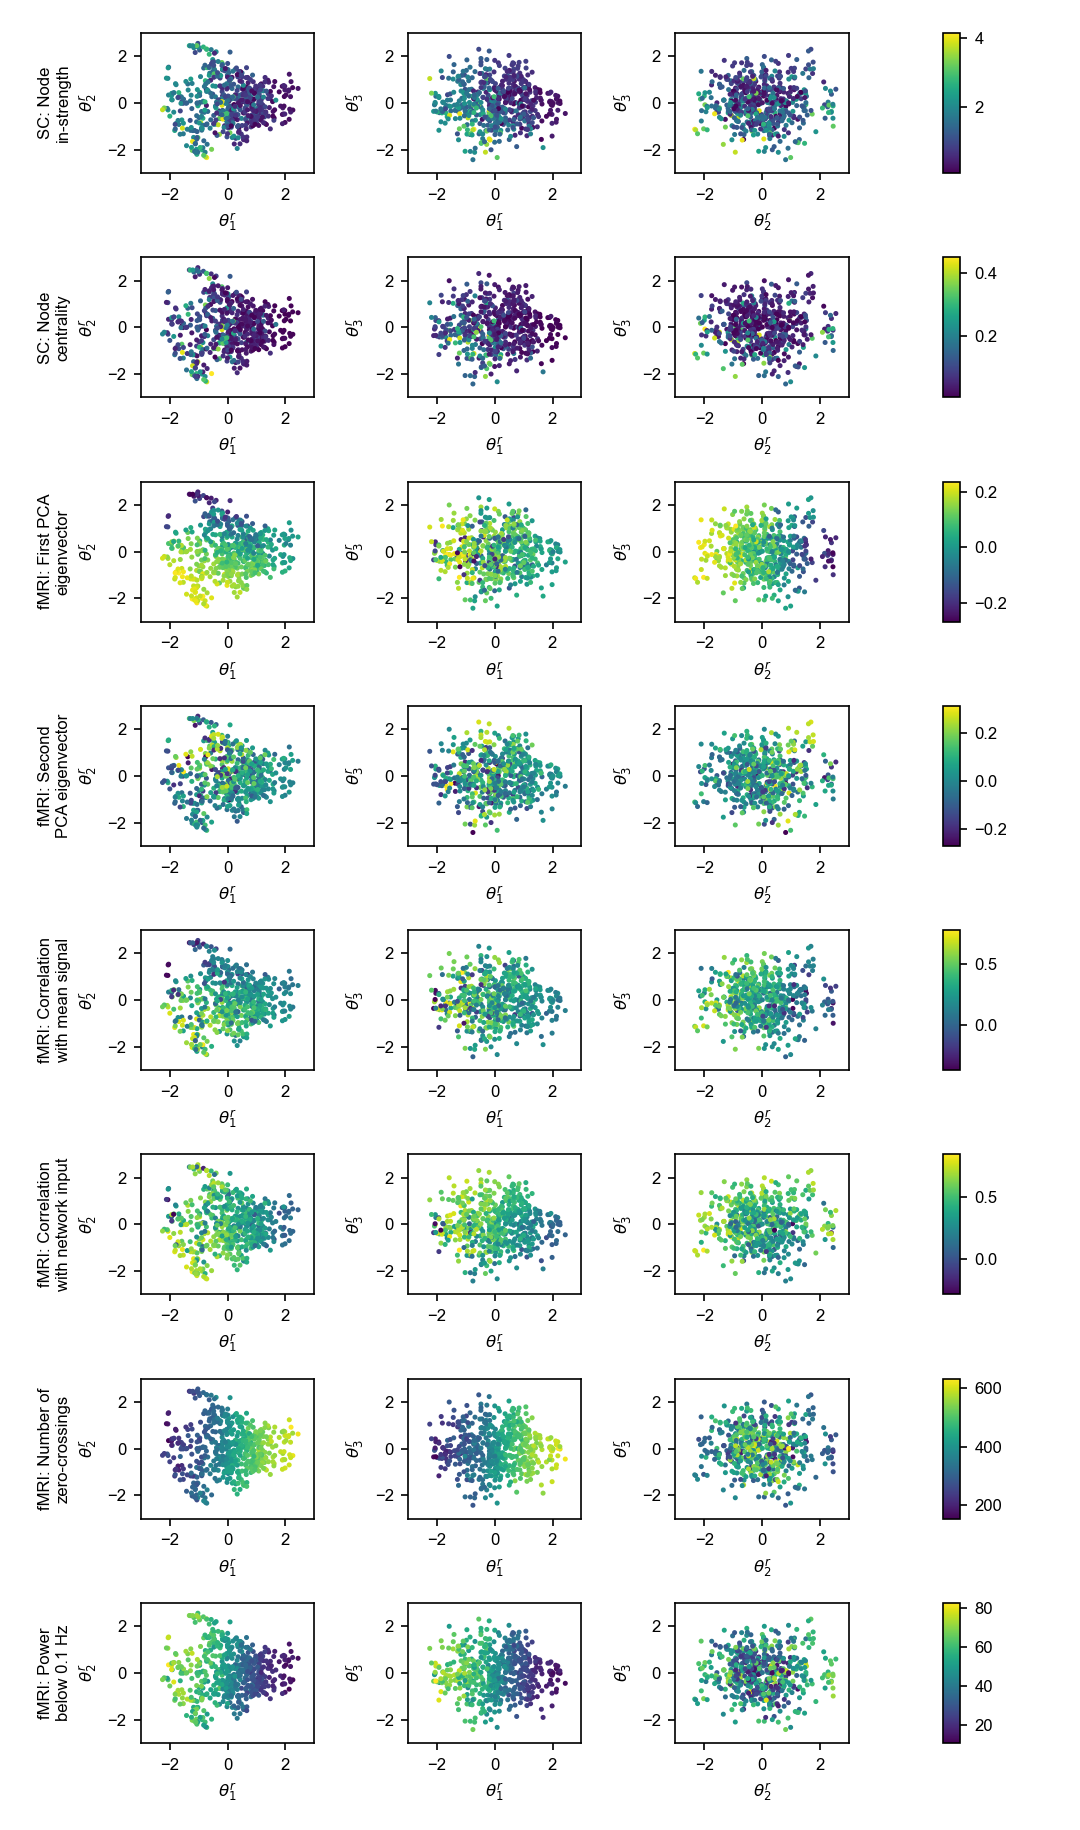

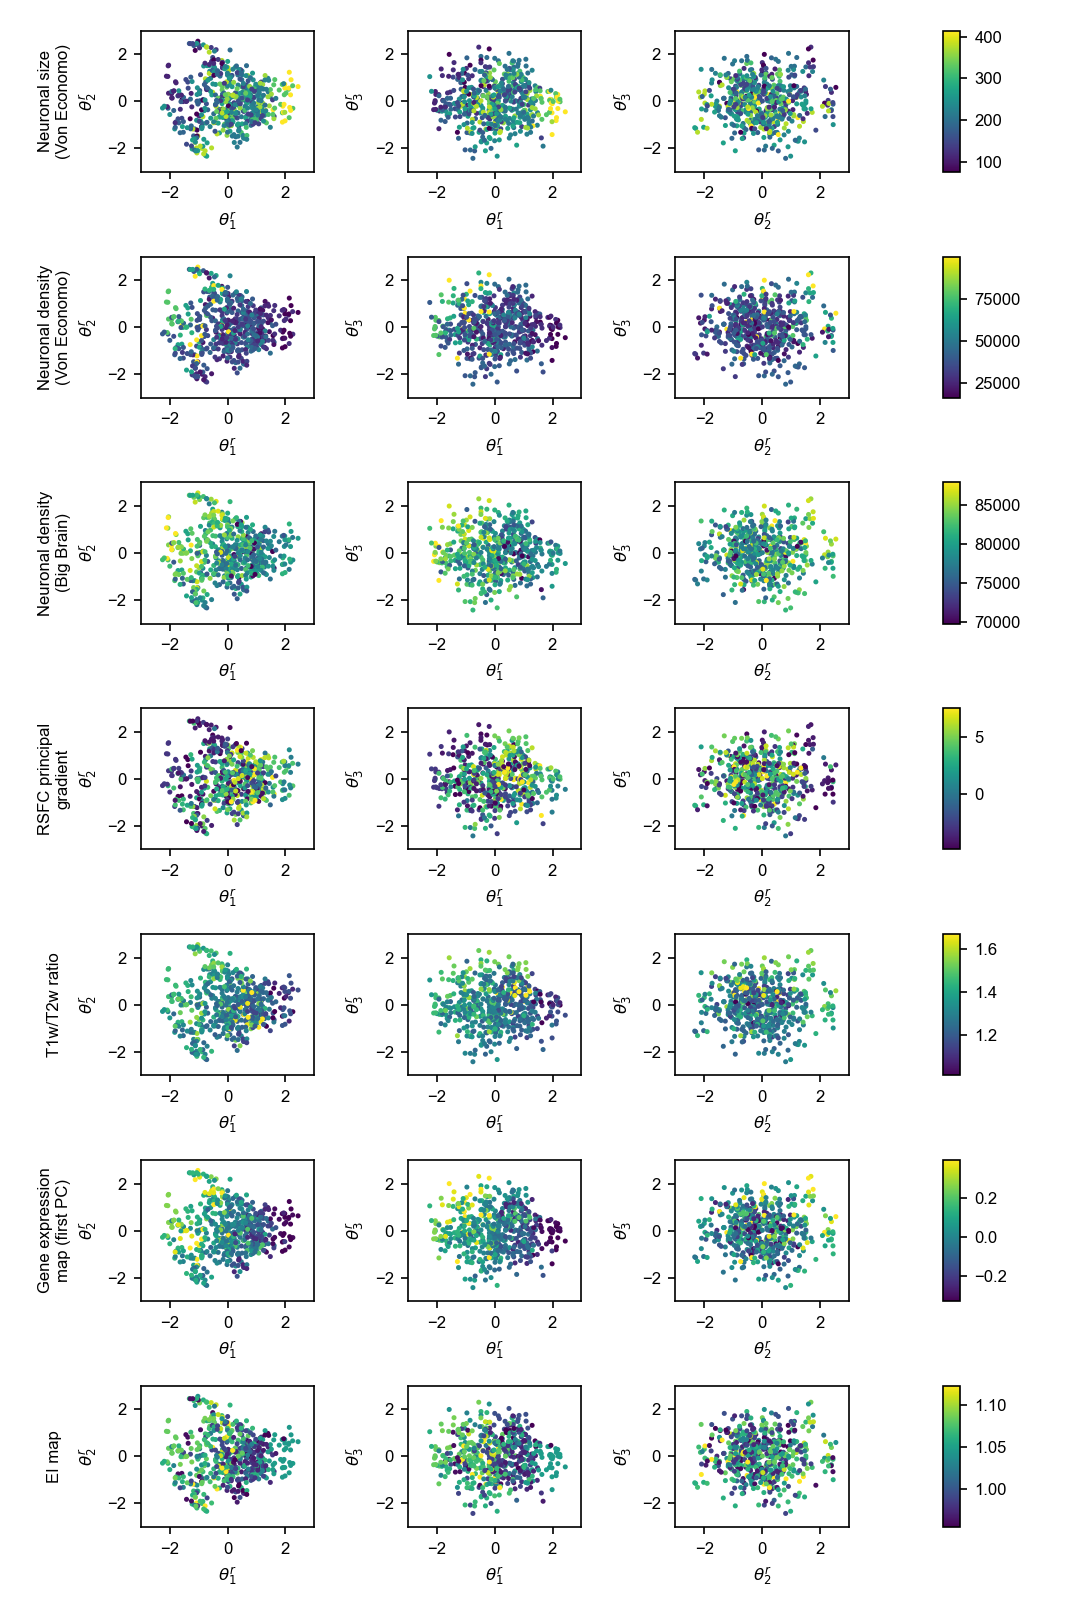

In [238]:
for group_name, features in feature_groups:    
    plt.figure(figsize=(7, 1.5*len(features)), dpi=150)    
    
    gs = matplotlib.gridspec.GridSpec(len(features), 4, width_ratios=[1,1,1,0.1], hspace=0.6, wspace=0.7,
                                     top=0.99, bottom=0.04, left=0.12, right=0.9)

    for i, (label, feature) in enumerate(features):
        for j, (i1,i2) in enumerate([(0,1),(0,2),(1,2)]):
            plt.subplot(gs[i,j])
            
            if j == 0:
                if len(label) > 14 and (' ' in label):
                    spaces = np.array([i for i, ch in enumerate(label) if ch == ' '])
                    best_space = spaces[np.argmin(np.abs(spaces - len(label)/2))]
                    label = label[:best_space] + '\n' + label[best_space+1:]
                    
                plt.text(-6, 0, label, rotation='vertical', ha='center', va='center', fontsize=8)
            
            p1, p2 = order[i1], order[i2]
            
            s = plt.scatter(df[f"thetareg{p1}_mu"], df[f"thetareg{p2}_mu"], s=2, c=df[feature], cmap='viridis')
            plt.xlabel(f"$\\theta^r_{i1+1}$")
            plt.ylabel(f"$\\theta^r_{i2+1}$")
            plt.xlim(-3,3)
            plt.ylim(-3,3)
            plt.xticks([-2,0,2])
            plt.yticks([-2,0,2])
                
            if j == 2:
                cax = plt.subplot(gs[i,3])
                plt.colorbar(s, cax)

    pu.Background(visible=False)
    plt.savefig(f"img/Fig_features_{group_name.replace(' ', '_')}.pdf")